In [1]:
import numpy as np
import pandas as pd

from utils import preprocess
import model
from model.cnn import OlidCnnNet
from utils import plotutils
from utils import trainutils

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
use_gpu = True

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print('Training using', device)

Training using cpu


In [4]:
DATA_DIR = "./data/"
TRAIN_DATA_FILE = DATA_DIR + "olid-training-v1.0.tsv"

In [5]:
ori_train_data = pd.read_csv(TRAIN_DATA_FILE, sep='\t')

In [6]:
%%time

tweet_doc = preprocess.spacy_pipeline(ori_train_data['tweet'].to_list())

CPU times: total: 1min 18s
Wall time: 1min 18s


In [7]:
tweet_normalized = preprocess.spacy_normalize(tweet_doc, stop_removal=False, lemmatized=False)
tweet_normalized = preprocess.remove_user_mask(tweet_normalized)

In [8]:
vocabulary, documents_padded = preprocess.transform_word_to_vector(tweet_normalized, num_vocab=10000, num_tokens=30)

# sub a

In [9]:
label2id = {'NOT': 0, 'OFF': 1}

In [10]:
sub_a_label = ori_train_data['subtask_a'].map(label2id).to_list()

In [11]:
sentences_train, sentences_test, labels_train, labels_test = train_test_split(documents_padded, sub_a_label, test_size=0.2, random_state=5246)

In [12]:
train_dataset = TensorDataset(sentences_train, torch.tensor(labels_train, dtype=torch.float32))
test_dataset = TensorDataset(sentences_test, torch.tensor(labels_test, dtype=torch.float32))

In [13]:
learning_rate = 1e-3
batch_size = 256
epochs = 50

In [14]:
seq_len = documents_padded.size(1)
num_vocab = documents_padded.max().item() + 1
cnn = OlidCnnNet(seq_len=seq_len, num_vocab=num_vocab, embedding_size=300, conv_out=8)

In [15]:
cnn

OlidCnnNet(
  (embedding): Embedding(10004, 300, padding_idx=0)
  (conv_1): Conv2d(1, 8, kernel_size=(2, 300), stride=(1, 1))
  (conv_2): Conv2d(1, 8, kernel_size=(3, 300), stride=(1, 1))
  (conv_3): Conv2d(1, 8, kernel_size=(4, 300), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=232, out_features=1, bias=True)
)

In [16]:
optimizer = optim.AdamW(cnn.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [18]:
trainutils.evaluate(cnn, test_dataloader, device)

  0%|          | 0/11 [00:00<?, ?it/s]

0.4060356364112786

In [19]:
results = trainutils.train(cnn, train_dataloader, test_dataloader, optimizer, criterion, epochs, device, verbose=True)

Total Training Time (total number of epochs: 50)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 001] loss:	27.503, f1 train: 0.485, f1 test: 0.445 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 002] loss:	25.037, f1 train: 0.556, f1 test: 0.462 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 003] loss:	23.127, f1 train: 0.719, f1 test: 0.548 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 004] loss:	20.857, f1 train: 0.809, f1 test: 0.595 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 005] loss:	18.232, f1 train: 0.842, f1 test: 0.603 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 006] loss:	15.696, f1 train: 0.892, f1 test: 0.617 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 007] loss:	13.451, f1 train: 0.917, f1 test: 0.618 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 008] loss:	11.260, f1 train: 0.941, f1 test: 0.627 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 009] loss:	9.574, f1 train: 0.958, f1 test: 0.645 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 010] loss:	8.083, f1 train: 0.966, f1 test: 0.648 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 011] loss:	6.992, f1 train: 0.973, f1 test: 0.650 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 012] loss:	6.028, f1 train: 0.978, f1 test: 0.647 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 013] loss:	5.296, f1 train: 0.984, f1 test: 0.660 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 014] loss:	4.795, f1 train: 0.987, f1 test: 0.661 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 015] loss:	4.054, f1 train: 0.990, f1 test: 0.662 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 016] loss:	3.646, f1 train: 0.991, f1 test: 0.658 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 017] loss:	3.215, f1 train: 0.992, f1 test: 0.660 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 018] loss:	2.987, f1 train: 0.993, f1 test: 0.663 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 019] loss:	2.642, f1 train: 0.993, f1 test: 0.662 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 020] loss:	2.444, f1 train: 0.994, f1 test: 0.663 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 021] loss:	2.244, f1 train: 0.995, f1 test: 0.662 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 022] loss:	2.131, f1 train: 0.995, f1 test: 0.657 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 023] loss:	1.893, f1 train: 0.995, f1 test: 0.655 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 024] loss:	1.837, f1 train: 0.996, f1 test: 0.666 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 025] loss:	1.840, f1 train: 0.996, f1 test: 0.663 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 026] loss:	1.770, f1 train: 0.996, f1 test: 0.655 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 027] loss:	1.555, f1 train: 0.997, f1 test: 0.657 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 028] loss:	1.482, f1 train: 0.996, f1 test: 0.659 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 029] loss:	1.411, f1 train: 0.996, f1 test: 0.663 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 030] loss:	1.347, f1 train: 0.997, f1 test: 0.661 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 031] loss:	1.425, f1 train: 0.997, f1 test: 0.662 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 032] loss:	1.297, f1 train: 0.997, f1 test: 0.658 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 033] loss:	1.312, f1 train: 0.997, f1 test: 0.661 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 034] loss:	1.197, f1 train: 0.997, f1 test: 0.660 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 035] loss:	1.141, f1 train: 0.997, f1 test: 0.662 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 036] loss:	0.983, f1 train: 0.997, f1 test: 0.666 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 037] loss:	1.054, f1 train: 0.997, f1 test: 0.663 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 038] loss:	0.982, f1 train: 0.997, f1 test: 0.668 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 039] loss:	1.028, f1 train: 0.997, f1 test: 0.660 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 040] loss:	0.931, f1 train: 0.997, f1 test: 0.658 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 041] loss:	0.964, f1 train: 0.997, f1 test: 0.664 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 042] loss:	0.940, f1 train: 0.997, f1 test: 0.658 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 043] loss:	0.930, f1 train: 0.997, f1 test: 0.656 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 044] loss:	0.859, f1 train: 0.997, f1 test: 0.654 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 045] loss:	0.770, f1 train: 0.997, f1 test: 0.663 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 046] loss:	0.747, f1 train: 0.997, f1 test: 0.663 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 047] loss:	0.771, f1 train: 0.997, f1 test: 0.657 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 048] loss:	0.834, f1 train: 0.997, f1 test: 0.656 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 049] loss:	0.834, f1 train: 0.998, f1 test: 0.660 


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 050] loss:	0.733, f1 train: 0.998, f1 test: 0.669 


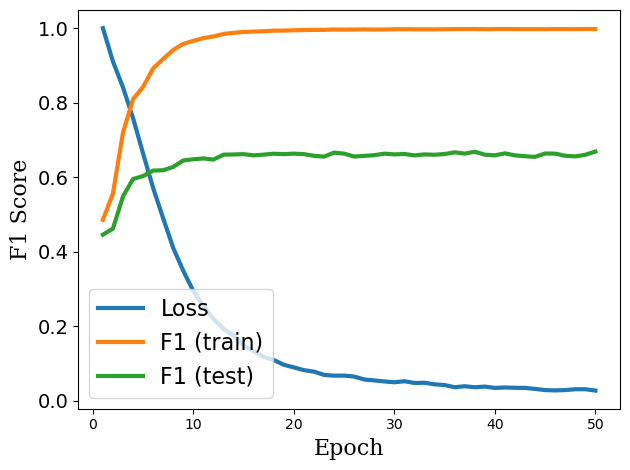

In [20]:
plotutils.plot_training_results(results)